## Inspecting Data

In [1]:
import gen_input
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

train_test_valid_split = [1., 0., 0.]
# From http://ufldl.stanford.edu/housenumbers/
svhn_train = gen_input.read_data_sets("data/train_32x32.mat", train_test_valid_split).train
svhn_test = gen_input.read_data_sets("data/test_32x32.mat", train_test_valid_split).train

# Data information
input_channels = svhn_train.images.shape[2]
image_size = int(np.sqrt(svhn_train.images.shape[1]))
n_classes = 10 # total classes (0-9 digits)

print svhn_train.images[0].shape
print svhn_train.images.shape
print svhn_test.images[0].shape
print svhn_test.images.shape

# per_img_means = svhn_train.images.mean(axis=1)
# # per_img_norm = svhn_train.images - per_img_means[:, np.newaxis, :]

# for i in range(4010, 4025):
#     fig = plt.figure()
#     ax = fig.add_subplot(1,1,1)
    
#     img = svhn_train.images[i]
#     lbl = np.argmax(svhn_train.labels[i])
#     ax.set_title(lbl)
#     img = img.reshape([32,32,3])
#     imgplot = plt.imshow(img)
#     plt.show()
    
# #     img_s = per_img_norm[i]
# #     img_s = img_s.reshape([32,32,3])
# #     imgplot = plt.imshow(img_s)
# #     plt.show()

(1024, 3)
(73257, 1024, 3)
(1024, 3)
(26032, 1024, 3)


(1024, 3)
(32, 32, 3)


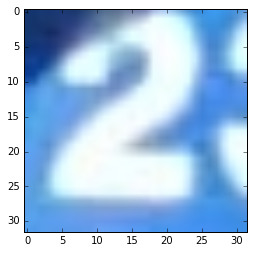

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = svhn_train.images[2]
print img.shape
img = img.reshape([32,32,3])
print img.shape
imgplot = plt.imshow(img, cmap='gray')
plt.show()
    
#     img_s = per_img_norm[i]
#     img_s = img_s.reshape([32,32,3])
#     imgplot = plt.imshow(img_s)
#     plt.show()

In [6]:
##########################################
##                                      ##
##            Helper Wrappers           ##
##                                      ##
##########################################

# Default stdev for weights and biases
init_std = 0.05
# Default decay, if non-zero
init_decay = 0.0025

# We can't initialize these variables to 0 - the network will get stuck.
def weight_variable(shape, stddev=init_std):
  """Create a weight variable with appropriate initialization."""
  initial = tf.truncated_normal(shape, stddev)
  return tf.Variable(initial)

def bias_variable(shape, default_bias=init_std):
  """Create a bias variable with appropriate initialization."""
  initial = tf.constant(default_bias, shape=shape)
  return tf.Variable(initial)

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

def convlayer(layer_name, input_tensor, receptive_field, channels_in, channels_out,
              padding='SAME', stride=1, act=tf.nn.relu, decay=0,
              pool=False, pooler=tf.nn.max_pool, pool_size=2, pool_stride=2, pool_padding='SAME',
              batch_norm=True, training=True):
  """General purpose convolutional layer, followed by pooling

  It does a matrix convolution, bias add, and then uses relu by default to nonlinearize.
  Then it pools using max pooling by default.
  It also sets up name scoping so that the resultant graph is easy to read,
  and adds a number of summary ops for TensorBoard.
  """
  # Adding a name scope ensures logical grouping of the layers in the graph.
  with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
    with tf.name_scope('weights'):
      weights = weight_variable([receptive_field, receptive_field, channels_in, channels_out])
      variable_summaries(weights)
      
      # Optional visualization of first layer
      if layer_name == 'conv1':
        weight_min = tf.reduce_min(weights)
        weight_max = tf.reduce_max(weights)
        weights_0_to_1 = (weights - weight_min) / (weight_max - weight_min)
        weights_transposed = tf.transpose(weights_0_to_1, [3, 0, 1, 2])
        tf.summary.image('filter', weights_transposed, 10) # Just follow 10 feature maps

      if decay > 0:
          weight_decay = tf.multiply(tf.nn.l2_loss(weights), decay, name='weight_decay')
          tf.add_to_collection('losses', weight_decay)
  
    with tf.name_scope('biases'):
      biases = bias_variable([channels_out])
      variable_summaries(biases)
      
    with tf.name_scope('W_conv_x_plus_b'):
      preactivate = tf.nn.conv2d(input_tensor, weights, 
                                 strides=[1, stride, stride, 1], 
                                 padding=padding) + biases
      tf.summary.histogram('pre_activations', preactivate)
    
    if batch_norm:
      with tf.name_scope('batchnorm'):
        normed = tf.layers.batch_normalization(preactivate, training=training)
      activations = act(normed, name='activation')
    else:
      activations = act(preactivate, name='activation')  
    tf.summary.histogram('activations', activations)
    
    if pool:
      max_pool = pooler(activations, ksize=[1, pool_size, pool_size, 1], 
                      strides=[1, pool_stride, pool_stride, 1],
                      padding=pool_padding)
      tf.summary.histogram('pools', max_pool)
      return max_pool
    else: 
      return activations
    
def nn_layer(layer_name, input_tensor, input_dim, output_dim, act=tf.nn.relu, decay=0):
  """Reusable code for making a normal neural net layer.
  It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
  It also sets up name scoping so that the resultant graph is easy to read,
  and adds a number of summary ops.
  """
  # Adding a name scope ensures logical grouping of the layers in the graph.
  with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
    with tf.name_scope('weights'):
      weights = weight_variable([input_dim, output_dim])
      
      if decay > 0:
        weight_decay = tf.multiply(tf.nn.l2_loss(weights), decay, name='weight_decay')
        tf.add_to_collection('losses', weight_decay)

      variable_summaries(weights)
    with tf.name_scope('biases'):
      biases = bias_variable([output_dim])
      variable_summaries(biases)
    with tf.name_scope('Wx_plus_b'):
      preactivate = tf.matmul(input_tensor, weights) + biases
      tf.summary.histogram('pre_activations', preactivate)
    activations = act(preactivate, name='activation')
    tf.summary.histogram('activations', activations)
    return activations
  
def flat_dimension(tensor):
  dim = 1 # Compute how many numbers we have, ignoring the batch size
  for d in tensor.get_shape()[1:].as_list():
    dim *= d
  return dim

In [7]:
def run():
  # RESET TF GRAPH, just in case
  tf.reset_default_graph()
  
  sess = tf.InteractiveSession() ###### May need to change for .py files

  ts = datetime.now().strftime('%Y%m%d_%H%M')
  logs_path = "logs/{}/".format(ts)
  
  ### Place holders ###
  # Optionally track that place holders are correctly set at test and train tme
  with tf.name_scope('test_train_variables'):
    training = tf.placeholder(tf.bool) # for batch_norm mode
    keep_prob = tf.placeholder(tf.float32) # for drop out
    tf.summary.scalar('training', tf.to_int32(training, name='ToInt32'))
    tf.summary.scalar('dropout_keep_probability', keep_prob)
  
  with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=[None, image_size*image_size, input_channels], name="x-input") 
    y_ = tf.placeholder(tf.float32, shape=[None, n_classes], name="y-input")
    
  ### Network ###
  with tf.name_scope('input_reshape'):
    input_reshaped = tf.reshape(x, [-1, image_size, image_size, input_channels])
    tf.summary.image('input', input_reshaped, 5) # Save 5 images to ensure reshape is working

  conv1 = convlayer(layer_name='conv1', input_tensor=input_reshaped, receptive_field=5, 
                      channels_in=input_channels, channels_out=64, pool=True, pool_size=2, pool_stride=2,
                      batch_norm=True, training=training)
  
  conv2 = convlayer(layer_name='conv2', input_tensor=conv1, receptive_field=5, 
                    channels_in=64, channels_out=64, pool=True, pool_size=2, pool_stride=2,
                    batch_norm=True, training=training)
  
  with tf.name_scope('conv2_flatten'):
    conv_reshaped = tf.reshape(conv2, [-1, flat_dimension(conv2)])

  fc1 = nn_layer(layer_name='fc1', input_tensor=conv_reshaped, input_dim=flat_dimension(conv2), output_dim=512, decay=init_decay)
  dropped1 = tf.nn.dropout(fc1, keep_prob)

  fc2 = nn_layer(layer_name='fc2', input_tensor=dropped1, input_dim=512, output_dim=256, decay=init_decay)
  dropped2 = tf.nn.dropout(fc2, keep_prob)

  # Do not apply softmax activation yet! use the identity
  y = nn_layer(layer_name='output', input_tensor=dropped2, input_dim=256, output_dim=n_classes, act=tf.identity) 
  

  # Cross-Entropy Loss
  with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
      cross_entropy = tf.reduce_mean(diff)
      tf.add_to_collection('losses', cross_entropy)
  tf.summary.scalar('cross_entropy', cross_entropy)
  # Total loss (weight decay + cross-entropy)
  total_loss = tf.add_n(tf.get_collection('losses'), name='total_loss')

  with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

  # Other metrics
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', accuracy)

  # Merge all the summaries and write them out
  merged = tf.summary.merge_all()
  train_writer = tf.summary.FileWriter(logs_path + '/train', sess.graph)
  test_writer = tf.summary.FileWriter(logs_path + '/test')

  # Normalize by subtracting per image, per channel means
  def normalize_batch(batch):
    per_img_ch_means = batch.mean(axis=1)
    return batch - per_img_ch_means[:, np.newaxis, :]

  # Different options for running the graph
  def feed_dict(mode):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if mode == 'Train':
      batch_x, batch_y = svhn_train.next_batch(batch_size)
      keep_proba = train_keep_prob
      training_ = True
    elif mode == 'Train_no_drop':
      batch_x, batch_y = svhn_train.next_batch(test_batch_size)
      keep_proba = 1.0
      training_ = True
    elif mode == 'Test':
      batch_x, batch_y = svhn_test.next_batch(test_batch_size)
      keep_proba = 1.0
      training_ = False
      
    batch_x = normalize_batch(batch_x) # Subtract per image mean
    return {x: batch_x, y_: batch_y, keep_prob: keep_proba, training: training_}

  # Might be needed for batch norm
  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  
  tf.global_variables_initializer().run()
  
  # Training loop
  for epoch in xrange(training_epochs):
    for batch_num in xrange(total_batches):
      if batch_num % test_every == test_every - 1:  
        # Record summaries and accuracy on the *test* set
        summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(mode='Test'))
        test_writer.add_summary(summary, epoch * total_batches + batch_num)
        print('Test accuracy at epoch %s - batch %s: %s' % (epoch, batch_num, acc))
        # Now proceed to train and produce corresponding training summary too
        summary, _, _ = sess.run([merged, train_step, extra_update_ops], feed_dict=feed_dict(mode='Train_no_drop'))
        train_writer.add_summary(summary, epoch * total_batches + batch_num)
      else:
        sess.run([train_step, extra_update_ops], feed_dict=feed_dict(mode='Train'))
  
  print "\nOptimization Finished!\n"
  if full_at_end:
    acc = sess.run([accuracy], feed_dict=feed_dict(mode='Final'))
    print('Accuracy at finish: %s' % (acc))
  print "-"* 70
  pwd = os.getcwd()+"/"
  print("Run the following to start tensorboard server:\n" \
        "tensorboard --logdir=/{}{}".format(pwd, logs_path))
  train_writer.close()
  test_writer.close()

In [8]:
##########################################
##                                      ##
##              Parameters              ##
##                                      ##
##########################################

learning_rate = 0.001 # Slightly higher since we are using batch norm
training_epochs = 3 # Typically overfits around 2.5 epochs
train_keep_prob = 0.98 # Low dropout, in addition to weight decay

# Train batch size
batch_size = 100 # Better at 128 or 256
total_batches = int(svhn_train.num_examples / batch_size) # Train on all of the data

# Test frequency / size
test_every = 2 # Record test accuracy every 500 batches (32*500 examples) -- ideally every 100
test_batch_size = int(0.01*svhn_test.num_examples) # Test on 10% of the data -- ideally 50% or more

# Whether to test the full accuracy at the end
full_at_end = True # test on a larger portion at the end (see feed dict)
final_test_batch = int(0.01*svhn_test.num_examples) # the percentage of data to test on at the end

run()

Test accuracy at epoch 0 - batch 1: 0.0923077
Test accuracy at epoch 0 - batch 3: 0.119231
Test accuracy at epoch 0 - batch 5: 0.0961538
Test accuracy at epoch 0 - batch 7: 0.115385
Test accuracy at epoch 0 - batch 9: 0.142308
Test accuracy at epoch 0 - batch 11: 0.203846
Test accuracy at epoch 0 - batch 13: 0.157692
Test accuracy at epoch 0 - batch 15: 0.111538
Test accuracy at epoch 0 - batch 17: 0.0923077
Test accuracy at epoch 0 - batch 19: 0.126923
Test accuracy at epoch 0 - batch 21: 0.1
Test accuracy at epoch 0 - batch 23: 0.161538
Test accuracy at epoch 0 - batch 25: 0.138462
Test accuracy at epoch 0 - batch 27: 0.15
Test accuracy at epoch 0 - batch 29: 0.192308
Test accuracy at epoch 0 - batch 31: 0.173077
Test accuracy at epoch 0 - batch 33: 0.203846
Test accuracy at epoch 0 - batch 35: 0.165385
Test accuracy at epoch 0 - batch 37: 0.173077
Test accuracy at epoch 0 - batch 39: 0.138462
Test accuracy at epoch 0 - batch 41: 0.184615
Test accuracy at epoch 0 - batch 43: 0.180769

# Optional: Gradients

In [ ]:
# # Place near the optimizer
# with tf.name_scope('Optimizer'):
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
#     ### Op to calculate every variable gradient ###
#     grads = tf.gradients(loss, tf.trainable_variables())
#     grads = list(zip(grads, tf.trainable_variables()))
    
#     ### Op to update all variables according to their gradient ###
#     apply_grads = optimizer.apply_gradients(grads_and_vars=grads)

#     # Summaries to visualize gradients
#     for grad, var in grads:
#         var_name = var.name.replace(":", "_") # to suppress the pesky warning
#         tf.summary.histogram(var_name + '_gradient', grad)